In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
import seaborn as sns
from scipy import stats
from scipy.optimize import minimize
from scipy.optimize import curve_fit

df = pd.read_csv(r"exoplanet_catalogue.csv")
print(len(df))

# column_list = df.columns.tolist()

# for col in df.columns:
#     data_type = df[col].dtype
#     print(f"Column '{col}': Data Type = {data_type}")


7408


In [3]:
df_mr = df[['star_mass','star_radius']].copy() # df with only mass and radius columns

c_df_mr = df_mr.dropna().copy()
print(len(c_df_mr))

r_df_mr = df_mr.dropna(subset=['star_radius']).copy() # all rows have radius
print(len(r_df_mr))
m_df_mr = df_mr.dropna(subset=['star_mass']).copy() # all rows have mass
print(len(m_df_mr))

5479
5738
6169


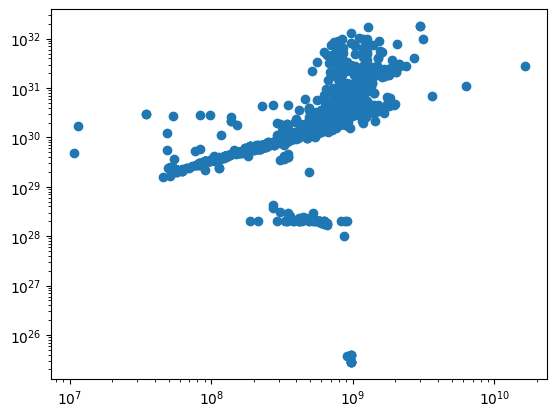

In [19]:
# ploting radius vs mass
y = c_df_mr["star_radius"] * 1.989e+30
x = c_df_mr["star_mass"] *6.957e+8

plt.scatter(x,y)
plt.xscale('log')
plt.yscale('log')
plt.scatter(0,0, color = 'red')
plt.show()

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 1.5700471637317103e+65
             x: [ 1.635e+02  2.984e+30 -9.495e-01]
           nit: 148
          nfev: 359
 final_simplex: (array([[ 1.635e+02,  2.984e+30, -9.495e-01],
                       [ 1.635e+02,  2.984e+30, -9.495e-01],
                       [ 1.635e+02,  2.984e+30, -9.495e-01],
                       [ 1.635e+02,  2.984e+30, -9.495e-01]]), array([ 1.570e+65,  1.570e+65,  1.570e+65,  1.570e+65]))
[1, 1e+28, 3]
[ 1.63534207e+02  2.98361154e+30 -9.49539180e-01]


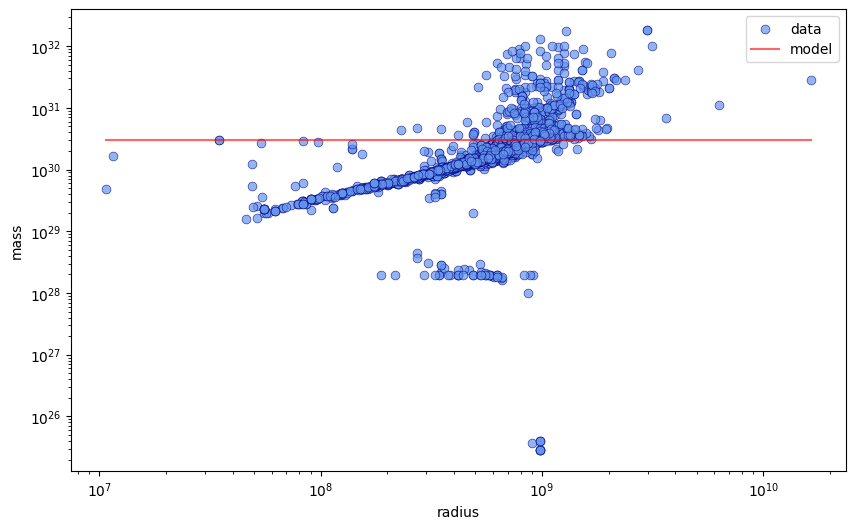

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from matplotlib.ticker import ScalarFormatter

# Create figure with appropriate size
plt.figure(figsize=(10, 6))

# Create scatter plot with better aesthetics
scatter = plt.scatter(x, y, alpha=0.7, s=40, c='cornflowerblue', edgecolor='navy', linewidth=0.5, label = 'data')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('radius')
plt.ylabel('mass')

def simple_mass_model(radius, d_star,inter,power):
    mass = (4/3 * np.pi  * radius ** power) * d_star + inter
    return mass

def loglikelihood(params):
    N = simple_mass_model(x,*params)
    LL = -np.sum(stats.norm.logpdf(y,loc=N))
    return LL

# init_d_rocky = 5 * 5.26704e-31 / (1.39876e-10 ** 3) # 5 gm/cm^3 converted into jupiter mass and jupiter radius units
# init_d_gas = 1 * 5.26704e-31 / (1.39876e-10 ** 3) # 5 gm/cm^3 converted into jupiter mass and jupiter radius units
# init_threshold_radius = 2 * 0.0892147 # 2 Earth radius converted into jupiter radius units

initparams = [1,1e28, 3]

results = minimize(loglikelihood, x0 = initparams, method = 'Nelder-Mead', tol = 1e-8)

print(results)
print(initparams)
print(results.x)

estParms = results.x
x_ = np.linspace(min(x),max(x),1000)
y_ =  simple_mass_model(x_,*estParms) 

plt.plot(x_,y_, color = 'r', alpha = 0.6, label = 'model')
plt.legend()
plt.show()

# print("final params")
# print(f" density of rocky planets = {estParms[0] / (5.26704e-31 / (1.39876e-10 ** 3)):.4f} gm/cm^3 \n density of gas planets = {estParms[1] / (5.26704e-31 / (1.39876e-10 ** 3)):.4f} gm/cm^3")
# print(f" threshold radius of rocky planets = {estParms[2] / 0.0892147 : .4f} Earth mass")


In [21]:
print(0.00432413 / (5.26704e-31 / (1.39876e-10 ** 3)))
print(0.19245845867328537 / (5.26704e-31 / (1.39876e-10 ** 3)))

0.022467861531306237
1.0


In [22]:
# Use a simpler approach with two separate linear models based on a mass threshold
# Determine breakpoint - we can use domain knowledge or try different values
# Common transition is around 10 Earth masses
breakpoint_mass = 0.0314558  # 10 Earth masses

# Create masks for rocky and gas planets
rocky_planets = x < breakpoint_mass
gas_planets = x >= breakpoint_mass

# Ensure we have enough data points in each category
if sum(rocky_planets) < 2 or sum(gas_planets) < 2:
    print("Not enough data points in one of the categories. Adjusting breakpoint...")
    # Adjust breakpoint to ensure at least 2 data points in each category
    sorted_masses = sorted(x)
    breakpoint_index = max(2, min(len(sorted_masses) - 2, int(len(sorted_masses) * 0.5)))
    breakpoint_mass = sorted_masses[breakpoint_index]
    rocky_planets = x < breakpoint_mass
    gas_planets = x >= breakpoint_mass
    print(f"New breakpoint mass: {breakpoint_mass}")

# Convert masks to numpy arrays
rocky_planets = np.array(rocky_planets)
gas_planets = np.array(gas_planets)

# Fit two separate linear models
model_rocky = LinearRegression().fit(log_x[rocky_planets].reshape(-1, 1), log_y[rocky_planets])
model_gas = LinearRegression().fit(log_x[gas_planets].reshape(-1, 1), log_y[gas_planets])

# Get slopes (in log space, these are the power law exponents)
rocky_slope = model_rocky.coef_[0]
gas_slope = model_gas.coef_[0]
rocky_intercept = model_rocky.intercept_
gas_intercept = model_gas.intercept_

# Generate points for the two lines
x_rocky = np.linspace(min(log_x), np.log10(breakpoint_mass), 500)
y_rocky = model_rocky.predict(x_rocky.reshape(-1, 1))
x_gas = np.linspace(np.log10(breakpoint_mass), max(log_x), 500)
y_gas = model_gas.predict(x_gas.reshape(-1, 1))

# Convert back to original scale and plot
plt.plot(10**x_rocky, 10**y_rocky, 'r-', linewidth=2, 
         label=f'Rocky planets (R ∝ M^{rocky_slope:.2f})')
plt.plot(10**x_gas, 10**y_gas, 'g-', linewidth=2, 
         label=f'Gas planets (R ∝ M^{gas_slope:.2f})')

# Add vertical line at breakpoint
plt.axvline(x=breakpoint_mass, color='grey', linestyle='--', alpha=0.5)

# Add text annotations describing the models
plt.text(min(x)*1.5, max(y)*0.7, f'Rocky planets: R ∝ M^{rocky_slope:.2f}', color='darkred')
plt.text(breakpoint_mass*1.5, max(y)*0.7, f'Gas planets: R ∝ M^{gas_slope:.2f}', color='darkgreen')

# Configure the log scales with better formatting
plt.xscale('log')
plt.yscale('log')
plt.gca().xaxis.set_major_formatter(ScalarFormatter())
plt.gca().yaxis.set_major_formatter(ScalarFormatter())

# Add labels and title
plt.xlabel('Mass (Earth masses)', fontsize=12)
plt.ylabel('Radius (Earth radii)', fontsize=12)
plt.title('Exoplanet Mass-Radius Relationship', fontsize=14)

# Add grid and legend
plt.grid(True, alpha=0.3, linestyle='--')
plt.legend(loc='lower left')

# Display number of planets in each category
n_rocky = np.sum(rocky_planets)
n_gas = np.sum(gas_planets)
plt.figtext(0.15, 0.85, f"Rocky planets: {n_rocky}", fontsize=10, 
            bbox={"facecolor":"lightcoral", "alpha":0.2, "pad":5})
plt.figtext(0.15, 0.80, f"Gas planets: {n_gas}", fontsize=10, 
            bbox={"facecolor":"lightgreen", "alpha":0.2, "pad":5})

# Add text explaining the physical interpretation
plt.figtext(0.5, 0.01, 
            "The mass-radius relationship changes at the transition between rocky and gas planets.\n"
            "Rocky planets (lower mass) have higher density, while gas planets (higher mass) have lower density.", 
            ha='center', fontsize=10, bbox={"facecolor":"lightgrey", "alpha":0.5, "pad":5})

# Adjust layout and display
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()

# Print the mathematical relationships
print(f"Rocky planets equation (M < {breakpoint_mass:.2f} Earth masses): R = {10**rocky_intercept:.4f} × M^{rocky_slope:.4f}")
print(f"Gas planets equation (M ≥ {breakpoint_mass:.2f} Earth masses): R = {10**gas_intercept:.4f} × M^{gas_slope:.4f}")

Not enough data points in one of the categories. Adjusting breakpoint...
New breakpoint mass: 667872000.0


NameError: name 'log_x' is not defined